### Packages Required

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score

from sklearn.linear_model import LogisticRegression

import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

### Datasets

In [47]:
Loans = pd.read_csv('C:/Users/Nithin/Downloads/Class 22 Python for Data Science (Self-paced) v4/bankloans - 1629574334696.csv')

### UDF

In [48]:
def continuous_var_summary( x ):
    
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total
    
    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    
    
    return pd.Series( [ x.dtype, x.nunique(), n_total, x.count(), n_miss, perc_miss,
                       x.sum(), x.mean(), x.std(), x.var(), 
                       lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max() ], 
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'nmiss', 'perc_miss',
                             'sum', 'mean', 'std', 'var',
                        'lc_iqr', 'uc_iqr',
                        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max']) 

In [49]:
def categoricar_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = True)[0:1].reset_index()
    
    return pd.Series(
        [x.count(),x.isnull().sum(),Mode.iloc[0,0],Mode.iloc[0,1],
        round(Mode.iloc[0,1] * 100 / x.count(),2)],
        
        index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT']
    )

In [50]:
def missing_imputation( x, stats = 'mean' ):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return x

In [51]:
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### Data Inspection

In [52]:
Loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [53]:
Loans.default.value_counts()

0.0    517
1.0    183
Name: default, dtype: int64

In [54]:
Loans.dtypes

age           int64
ed            int64
employ        int64
address       int64
income        int64
debtinc     float64
creddebt    float64
othdebt     float64
default     float64
dtype: object

### Splitting based on dtypes

In [55]:
cont = Loans.select_dtypes(['int64','float64']).columns
cat = Loans.select_dtypes(['object']).columns

In [56]:
Loans_cont = Loans[cont]

In [57]:
Loans.apply(continuous_var_summary)

#Remove the 150 Rows in y variable

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
dtype,int64,int64,int64,int64,int64,float64,float64,float64,float64
cardinality,37,5,33,32,129,245,842,848,2
n_tot,850,850,850,850,850,850,850,850,850
n,850,850,850,850,850,850,850,850,700
nmiss,0,0,0,0,0,0,0,0,150
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.647059
sum,29775,1454,7281,7116,39674,8645.9,1340.284021,2616.970979,183.0
mean,35.029412,1.710588,8.565882,8.371765,46.675294,10.171647,1.576805,3.078789,0.261429
std,8.041432,0.927784,6.777884,6.895016,38.543054,6.719441,2.12584,3.398803,0.439727
var,64.664623,0.860783,45.939706,47.541251,1485.566998,45.150891,4.519196,11.551864,0.19336


In [58]:
Loans_cont.dropna(axis=0,subset=['default'],inplace=True)

### Outlier Treatment

In [59]:
Loans_cont = Loans_cont.apply(lambda x : x.clip(lower = x.quantile(0.01),
                                  upper = x.quantile(0.99)))

In [60]:
Loans_cont.apply(continuous_var_summary)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,34,4,29,28,107,221,683,687,2
n_tot,700,700,700,700,700,700,700,700,700
n,700,700,700,700,700,700,700,700,700
nmiss,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,24393.07,1201.0,5851.07,5771.07,31394.1,7155.507,1049.190134,2119.103279,183.0
mean,34.847243,1.715714,8.358671,8.244386,44.848714,10.222153,1.498843,3.02729,0.261429
std,7.954735,0.906523,6.566008,6.721915,31.942133,6.68216,1.788451,3.115401,0.439727
var,63.277806,0.821784,43.112459,45.18414,1020.29987,44.651264,3.198555,9.705723,0.19336


### Missing value treatment

In [61]:
Loans_cont.apply(missing_imputation)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41.0,3.0,17.0,12.0,176.0,9.3,9.891428,5.008608,1.0
1,27.0,1.0,10.0,6.0,31.0,17.3,1.362202,4.000798,0.0
2,40.0,1.0,15.0,14.0,55.0,5.5,0.856075,2.168925,0.0
3,41.0,1.0,15.0,14.0,120.0,2.9,2.658720,0.821280,0.0
4,24.0,2.0,2.0,0.0,28.0,17.3,1.787436,3.056564,1.0
...,...,...,...,...,...,...,...,...,...
695,36.0,2.0,6.0,15.0,27.0,4.6,0.262062,0.979938,1.0
696,29.0,2.0,6.0,4.0,21.0,11.5,0.369495,2.045505,0.0
697,33.0,1.0,15.0,3.0,32.0,7.6,0.491264,1.940736,0.0
698,45.0,1.0,19.0,22.0,77.0,8.4,2.302608,4.165392,0.0


In [62]:
Loans_cont.apply(continuous_var_summary)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,34,4,29,28,107,221,683,687,2
n_tot,700,700,700,700,700,700,700,700,700
n,700,700,700,700,700,700,700,700,700
nmiss,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,24393.07,1201.0,5851.07,5771.07,31394.1,7155.507,1049.190134,2119.103279,183.0
mean,34.847243,1.715714,8.358671,8.244386,44.848714,10.222153,1.498843,3.02729,0.261429
std,7.954735,0.906523,6.566008,6.721915,31.942133,6.68216,1.788451,3.115401,0.439727
var,63.277806,0.821784,43.112459,45.18414,1020.29987,44.651264,3.198555,9.705723,0.19336


### Corelation Matrix

In [63]:
Loans_cont.corr().to_csv('C:/Users/Nithin/Downloads/Class 22 Python for Data Science (Self-paced) v4/corel.csv')

<AxesSubplot:>

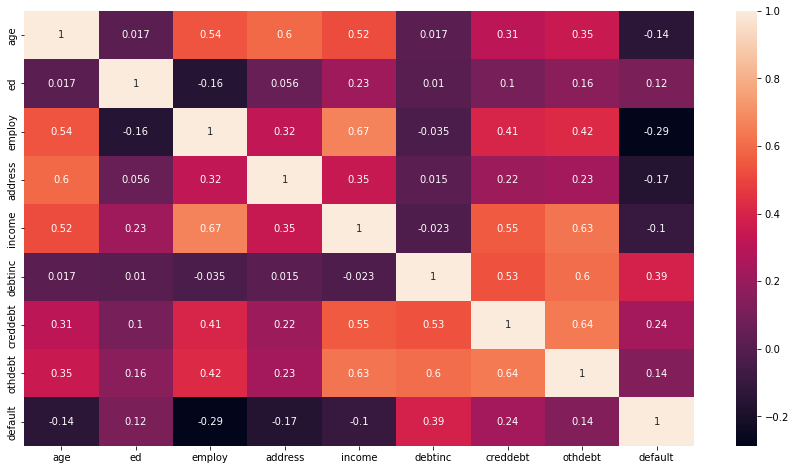

In [64]:
plt.figure(figsize= (15,8))
sns.heatmap(Loans_cont.corr(),annot=True)

### Feature Reduction

##### Somar'D

In [65]:
# empty dataframe
df_somarsd = pd.DataFrame()

# run the loop for all X variables
for var_name in Loans_cont.columns.difference(['default']):
    
    # bi variate classification
    logistic_mod = smf.logit( formula = 'default ~ ' + var_name, data = Loans_cont ).fit()
    
    # predict the y probabilities
    y_pred = logistic_mod.predict()
    
    # get the roc_auc_score or concordance
    roc_auc = roc_auc_score( Loans_cont.default, y_pred )
    
    # Somars' D value
    SomarsD = 2 * roc_auc - 1
    
    df_somarsd = pd.concat( [df_somarsd, pd.DataFrame([var_name, roc_auc, SomarsD]).T ] )

# rename the variables
df_somarsd.columns = ['Feature', 'roc_auc', 'SomarsD']

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


In [66]:
df_somarsd.sort_values(by = 'SomarsD', ascending = False)

#To remove
#otherdebt
#ed

,Feature,roc_auc,SomarsD
0,debtinc,0.735253,0.470506
0,employ,0.704569,0.409138
0,creddebt,0.636189,0.272378
0,address,0.611192,0.222384
0,age,0.603165,0.206329
0,income,0.600136,0.200273
0,othdebt,0.586903,0.173806
0,ed,0.574151,0.148302


In [67]:
features = list(df_somarsd.loc[df_somarsd.SomarsD >= 0.2,'Feature'])
features

['address', 'age', 'creddebt', 'debtinc', 'employ', 'income']

##### VIF

In [68]:
# run the dmatrices
equation = 'default ~ ' + ' + '.join( features)

a, b = dmatrices( equation, data = Loans_cont, return_type = 'dataframe')

# get the VIF
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

vif

,VIF Factor,features
0,28.286222,Intercept
1,1.559236,address
2,2.036933,age
3,2.564921,creddebt
4,1.778339,debtinc
5,1.997947,employ
6,2.601717,income


### Train & Test Model

In [69]:
train,test = train_test_split(Loans_cont,test_size=0.3,random_state=12345)

### Building a Model

In [70]:
predictors = train.columns.difference(['default','othdebt','ed','age','income'])

##### Model 0

In [71]:
m0 = 'default ~ ' + '+' .join(predictors)

In [72]:
lm0 = smf.logit(formula=m0,data=train).fit()

Optimization terminated successfully.
         Current function value: 0.397296
         Iterations 7


In [73]:
print(lm0.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.320     
Dependent Variable: default          AIC:              399.3504  
Date:               2022-10-15 11:12 BIC:              420.3224  
No. Observations:   490              Log-Likelihood:   -194.68   
Df Model:           4                LL-Null:          -286.49   
Df Residuals:       485              LLR p-value:      1.2380e-38
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.6661    0.3130  -2.1279  0.0333  -1.2796  -0.0526
address       -0.0944    0.0245  -3.8580  0.0001  -0.1423  -0.0464
creddebt       0.6765    0.1079   6.2716  0.0000   0.4651   0.8879
debtinc        0.0873    0.022

### Predict Values

In [85]:
train_predict = pd.DataFrame(lm0.predict(train))
test_predict = pd.DataFrame(lm0.predict(test))

### Model Scoring

In [86]:
train_auc = roc_auc_score(train.default, train_predict)
test_auc = roc_auc_score(test.default, test_predict)

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

The AUC for the model built on the Train Data is :  0.8599439775910365
The AUC for the model built on the Test Data is :  0.8340000000000001


### Combine Y & predicted Y

In [91]:
train_pf = pd.concat([train.default,train_predict],axis = 1)
test_pf = pd.concat([test.default,test_predict],axis = 1)

In [96]:
train_pf.columns = ['default','prob']
test_pf.columns = ['default','prob']

In [97]:
#Train predicted with 0.3 cutoff
train_pf['pred'] = train_pf.prob.apply(lambda x : 0.0 if x < 0.3 else 1.0)

In [98]:
train_pf

,default,prob,pred
148,0.0,0.085977,0.0
684,0.0,0.008984,0.0
519,0.0,0.065842,0.0
543,1.0,0.755161,1.0
334,0.0,0.278239,0.0
...,...,...,...
420,1.0,0.471880,1.0
129,0.0,0.015334,0.0
285,0.0,0.033491,0.0
485,0.0,0.149884,0.0


### Finding Best cutoff

In [106]:
roc_df = pd.DataFrame()

train_temp = train_pf.copy()

for cutoff in np.arange(0,1.01,0.01):
    
    train_temp['pred'] = train_temp.prob.apply(lambda x : 1 if x >= cutoff else 0)
    
    cm = confusion_matrix(train_temp.default,train_temp.pred)
    
    tp = cm[1,1]
    tn = cm[0,0]
    fp = cm[0,1]
    fn = cm[1,0]
    
    sensitivity = tp/(tp+fn)
    specificity = tn/(fp+tn)
    accuracy = (tp+tn)/train_temp.shape[0]
    
    temp = pd.DataFrame([cutoff,tp,tn,fp,fn,sensitivity,specificity,accuracy]).T
    roc_df = pd.concat([roc_df,temp],axis=0)
    
    roc_df

In [109]:
roc_df.columns = ['cutoff','tp','tn','fp','fn','sensitivity','specificity','accuracy']

In [112]:
roc_df['sen_spec'] = roc_df.sensitivity + roc_df.specificity

In [114]:
roc_df[roc_df.sen_spec == max(roc_df.sen_spec)]

,cutoff,tp,tn,fp,fn,sensitivity,specificity,accuracy,sen_spec
0,0.31,103.0,289.0,68.0,30.0,0.774436,0.809524,0.8,1.58396


### train pred based on 0.31 cutoff

In [117]:
train_pf['pred'] = train_pf.prob.apply(lambda x : 0.0 if x < 0.31 else 1.0)
test_pf['pred'] = test_pf.prob.apply(lambda x : 0.0 if x < 0.31 else 1.0)

In [119]:
confusion_matrix(train_pf.default,train_pf.pred)

array([[289,  68],
       [ 30, 103]], dtype=int64)

In [122]:
print(classification_report(train_pf.default,train_pf.pred))

              precision    recall  f1-score   support

         0.0       0.91      0.81      0.86       357
         1.0       0.60      0.77      0.68       133

    accuracy                           0.80       490
   macro avg       0.75      0.79      0.77       490
weighted avg       0.82      0.80      0.81       490



In [123]:
confusion_matrix(test_pf.default,test_pf.pred)

array([[119,  41],
       [ 12,  38]], dtype=int64)

In [124]:
print(classification_report(test_pf.default,test_pf.pred))

              precision    recall  f1-score   support

         0.0       0.91      0.74      0.82       160
         1.0       0.48      0.76      0.59        50

    accuracy                           0.75       210
   macro avg       0.69      0.75      0.70       210
weighted avg       0.81      0.75      0.76       210



### Decile Analysis

In [126]:
train_pf['decile'] = pd.qcut(train_pf.prob,10,labels=False)
test_pf['decile'] = pd.qcut(test_pf.prob,10,labels=False)

In [143]:
train_da = train_pf.groupby('decile')[['prob','default']].agg({'prob': [np.min,np.max],
                                                   'default':[np.sum,'count']}).reset_index().sort_values(by = 'decile',ascending = False)

In [145]:
test_da = test_pf.groupby('decile')[['prob','default']].agg({'prob': [np.min,np.max],
                                                   'default':[np.sum,'count']}).reset_index().sort_values(by = 'decile',ascending = False)

In [150]:
test_da.to_csv('C:/Users/Nithin/Downloads/Class 22 Python for Data Science (Self-paced) v4/test_da.csv')
train_da.to_csv('C:/Users/Nithin/Downloads/Class 22 Python for Data Science (Self-paced) v4/train_da.csv')